# Assignment 2
The objective of this assignment is to get you familiarizewith  the  problems  of  `classification`  and  `verification`with a popular problem space of `face`

This jupyter notebook is meant to be used in conjunction with the full questions in the assignment pdf.

## Instructions
- Write your code and analyses in the indicated cells.
- Ensure that this notebook runs without errors when the cells are run in sequence.
- Do not attempt to change the contents of the other cells.

## Allowed Libraries
- All libraries are allowed 

## Datasets 
- 3 datasets are provided. Load the data from the drive [link](!https://drive.google.com/file/d/1ujsKv9W5eidb4TXt1pnsqwDKVDFtzZTh/view?usp=sharing).
- Unzip the downloaded file and store the files in a folder called `datasets`. Keep the `datasets` folder in the same directory as of the jupyter notebook 

## Submission
- Ensure that this notebook runs without errors when the cells are run in sequence.
- Rename the notebook to `<roll_number>.ipynb` and submit ONLY the notebook file on moodle.
- Upload  the  notebook,  report  and  classification  results as a zip file to moodle. Name the zip file as `<rollnumber>_assignment2.zip`

In [263]:
# Installing Libraries
!pip install scikit-learn matplotlib Pillow

You are using pip version 9.0.1, however version 19.3.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [264]:
# Basic Imports
import os
import sys
import warnings
import numpy as  np
import pandas as pd
from scipy import linalg
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
import seaborn as sn
from sklearn.manifold import TSNE
from sklearn.neighbors import KNeighborsClassifier
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold

# Loading and plotting data
from PIL import Image
import matplotlib.pyplot as plt 
from mpl_toolkits.mplot3d import Axes3D

# Features
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
from sklearn.discriminant_analysis import _class_means,_class_cov
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.manifold import TSNE
from sklearn.manifold import Isomap

#Warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()
%matplotlib inline

# Parameters
- Image size: Bigger images create better representation but would require more computation. Choose the correct image size based on your Laptop configuration. 
- is_grayscale: Should you take grayscale images? Or rgb images? Choose whichever gives better representation for classification. 

In [265]:
opt = {
    'image_size': 64,
    'is_grayscale': False,
    'val_split': 0.75
}

### Load Dataset

In [266]:
cfw_dict = {'Amitabhbachan': 0,
    'AamirKhan': 1,
    'DwayneJohnson': 2,
    'AishwaryaRai': 3,
    'BarackObama': 4,
    'NarendraModi': 5,
    'ManmohanSingh': 6,
    'VladimirPutin': 7}

imfdb_dict = {'MadhuriDixit': 0,
     'Kajol': 1,
     'SharukhKhan': 2,
     'ShilpaShetty': 3,
     'AmitabhBachan': 4,
     'KatrinaKaif': 5,
     'AkshayKumar': 6,
     'Amir': 7}

# Load Image using PIL for dataset
def load_image(path):
    im = Image.open(path).convert('L' if opt['is_grayscale'] else 'RGB')
    im = im.resize((opt['image_size'],opt['image_size']))
    im = np.array(im)
    im = im/256
    return im

# Load the full data from directory
def load_data(dir_path):
    image_list = []
    y_list = []
    
    if "CFW" in dir_path:
        label_dict = cfw_dict

    elif "yale" in dir_path.lower():
        label_dict = {}
        for i in range(15):
            label_dict[str(i+1)] = i
    elif "IMFDB" in dir_path:
        label_dict = imfdb_dict
    else:
        raise KeyError("Dataset not found.")
    
    
    for filename in sorted(os.listdir(dir_path)):
        if filename.endswith(".png"):
            im = load_image(os.path.join(dir_path,filename))
            y = filename.split('_')[0]
            y = label_dict[y] 
            image_list.append(im)
            y_list.append(y)
        else:
            continue

    image_list = np.array(image_list)
    y_list = np.array(y_list)

    print("Dataset shape:",image_list.shape)

    return image_list,y_list

# Display N Images in a nice format
def disply_images(imgs,classes,row=1,col=2,w=64,h=64):
    fig=plt.figure(figsize=(8, 8))
    for i in range(1, col*row +1):
        img = imgs[i-1]
        fig.add_subplot(row, col, i)
        
        if opt['is_grayscale']:
            plt.imshow(img , cmap='gray') 
        else:
            plt.imshow(img)
        
        plt.title("Class:{}".format(classes[i-1]))
        plt.axis('off')
    plt.show()

In [267]:
# Loading the dataset
# eg.
dirpath = './dataset/IMFDB/'
X,y = load_data(dirpath)
N,H,W = X.shape[0:3]
C = 1 if opt['is_grayscale'] else X.shape[3]
dirpath2 = './dataset/Yale_face_database/'
X2,y2 = load_data(dirpath2)
N2,H2,W2 = X2.shape[0:3]
C2 = 1 if opt['is_grayscale'] else X2.shape[3]
X2 = X2.reshape((N2,H2*W2*C2))
dirpath3 = './dataset/IIIT-CFW/'
X3,y3 = load_data(dirpath3)
N3,H3,W3 = X3.shape[0:3]
C3 = 1 if opt['is_grayscale'] else X3.shape[3]
X3 = X3.reshape((N3,H3*W3*C3))

Dataset shape: (400, 64, 64, 3)
Dataset shape: (165, 64, 64, 3)
Dataset shape: (672, 64, 64, 3)


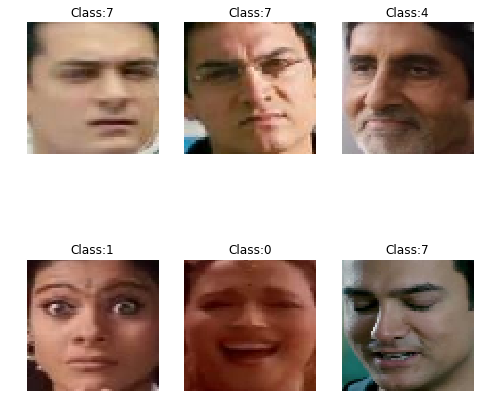

In [268]:
# Show sample images
ind = np.random.randint(0,y.shape[0],6)
disply_images(X[ind,...],y[ind], row=2,col=3)

# Features
    You are provided 6 Features. These features are:
   - Eigen Faces / PCA 
   - Kernel PCA
   - Fisher Face / LDA
   - Kernel Fisher Face
   - VGG Features 
   - Resnet Features

**VGG and Resnet features are last layer features learned by training a model for image classification**
    
---


In [269]:
# Flatten to apply PCA/LDA
X = X.reshape((N,H*W*C))

###  1. Eigen Face:
Use principal component analysis to get the eigen faces. 
Go through the [documentation](!http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) on how to use it

In [270]:
def get_pca(X,k):
    """
        Get PCA of K dimension using the top eigen vectors 
    """
    pca = PCA(n_components=k)
    X_k = pca.fit_transform(X)
    X_ik=pca.inverse_transform(X_k)
    return (X_k,X_ik,pca)

###  2. Kernel Face:
Use Kernel principal component analysis to get the eigen faces. 

There are different kernels that can be used. Eg. Poly, rbf, sigmoid. Choose the whichever gives the best result or representation. See [link](!https://data-flair.training/blogs/svm-kernel-functions/) for better understanding of these kernels  

Go through the [documentation](!https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.KernelPCA.html#sklearn.decomposition.KernelPCA) on how to use it different kernels in Sklearn. 

In [271]:
def get_kernel_pca(X, k,test,kernel='linear', degree=3):
    """
        Get PCA of K dimension using the top eigen vectors 
        @param: X => Your data flattened to D dimension
        @param: k => Number of components
        @param: kernel => which kernel to use (“linear” | “poly” | “rbf” | “sigmoid” | “cosine” )
        @param: d => Degree for poly kernels. Ignored by other kernels
    """
    kpca = KernelPCA(n_components=k,kernel=kernel,degree=degree,fit_inverse_transform=True)
    X_k = kpca.fit_transform(X)
    test_f=kpca.transform(test)
    return (X_k,test_f)

### 3. Fisher Face
Another method similar to the eigenface technique is `fisherfaces` which uses linear discriminant analysis.
This method for facial recognition is less sensitive to variation in lighting and pose of the face than using eigenfaces. Fisherface uses labelled data to retain more of the class-specific information during the dimension reduction stage.

Go through the [documentation](!https://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.LinearDiscriminantAnalysis.html) on how to use it different kernels in Sklearn. 

In [272]:
def get_lda(X,y,test, k=7):
    """
        Get LDA of K dimension 
        @param: X => Your data flattened to D dimension
        @param: k => Number of components
    """
    lda = LDA(n_components=k)
    X_k = lda.fit_transform(X,y)
    test_f=lda.transform(test)
    return (X_k,test_f)

### 4. Kernel Fisher Face
Use LDA using different kernels similiar to KernelPCA. Here the input is directly transformed instead of using the kernel trick.  

In [273]:
def get_kernel_lda(X,y,test,k=7,kernel='rbf',degree=3):
    """
        Get LDA of K dimension 
        @param: X => Your data flattened to D dimension
        @param: k => Number of components
        @param: kernel => which kernel to use ( “poly” | “rbf” | “sigmoid”)
    """
    # Transform  input
    if kernel == "poly":
        X_transformed = X**degree
    elif kernel == "rbf":
        var = np.var(X)
        X_transformed= np.exp(-X/(2*var))
    elif kernel == "sigmoid":
        X_transformed = np.tanh(X)
    else: 
        raise NotImplementedError("Kernel {} Not defined".format(kernel))
    klda = LDA(n_components=k)
    X_k = klda.fit_transform(X,y)
    test_f=klda.transform(test)
    return (X_k,test_f)

### 5. VGG Features
VGG Neural Networks a 19 layer CNN architecture introduced by Andrew Zisserman([Link](!https://arxiv.org/pdf/1409.1556.pdf) to paper). We are providing you with the last fully connected layer of this model.

The model was trained for face classification on each dataset and each feature the dimension of 4096.

In [274]:
def get_vgg_features(dirpath):
    features = np.load(os.path.join(dirpath,"VGG19_features.npy"))
    return features

### 6. Resnet Features

[Residual neural networks](!https://arxiv.org/pdf/1512.03385.pdf) are CNN with large depth, to effectively train these netwrorks they utilize skip connections, or short-cuts to jump over some layers. This helps solving [vanishing gradient problem](!https://en.wikipedia.org/wiki/Vanishing_gradient_problem) 

A 50 layer resnet model was trained for face classification on each dataset. Each feature the dimension of 2048

In [275]:
def get_resnet_features(dirpath):
    features = np.load(os.path.join(dirpath,"resnet50_features.npy"))
    return features

# Questions

1(a). What are eigen faces? 

___________________________

Eigen Faces are the eigen vectors of the covariance matrix of a large set of images depicting human faces which are used to represent the image. We can call them the principal components of the images. Any human face can be considered to be a combination of these standard faces.


1(b).  How many eigen vec-tors/faces are required to “satisfactorily” reconstruct a  person  in  these  three  datasets? (Don’t  forget  to make your argument based on eigen value spectrum) Show appropriate graphs, qualitative examples andmake a convincing argument.

In [276]:
# Compute your features 
Xf1=get_pca(X,400)[0]
Xf2=get_pca(X2,165)[0]
Xf3=get_pca(X3,672)[0]

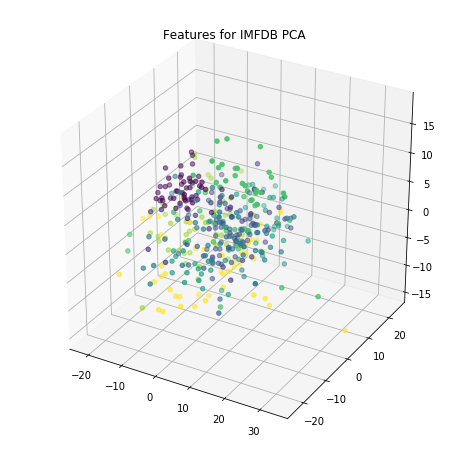

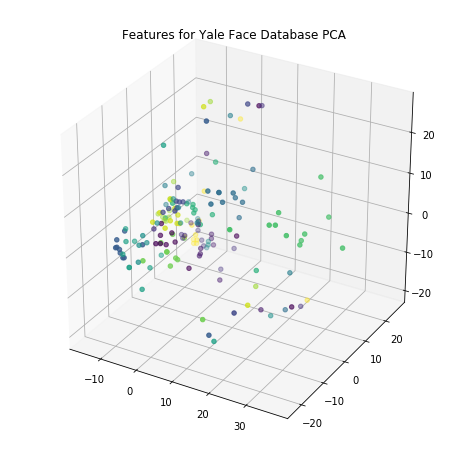

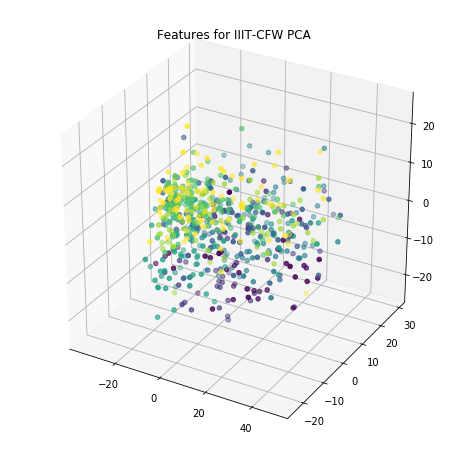

In [277]:
# Create a scatter plot 
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
plt.title('Features for IMFDB PCA')
ax.scatter(Xf1[:,0],Xf1[:,1],Xf1[:,2],c=y)
plt.show()
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
plt.title('Features for Yale Face Database PCA')
ax.scatter(Xf2[:,0],Xf2[:,1],Xf2[:,2],c=y2)
plt.show()
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
plt.title('Features for IIIT-CFW PCA')
ax.scatter(Xf3[:,0],Xf3[:,1],Xf3[:,2],c=y3)
plt.show()

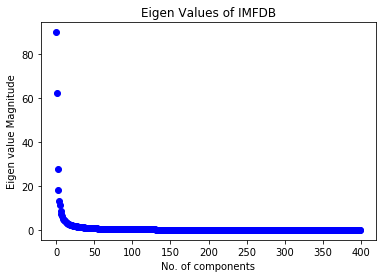

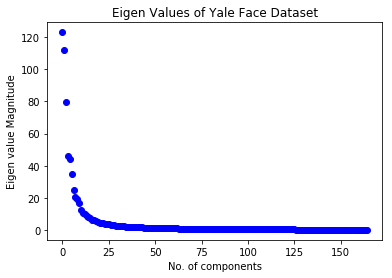

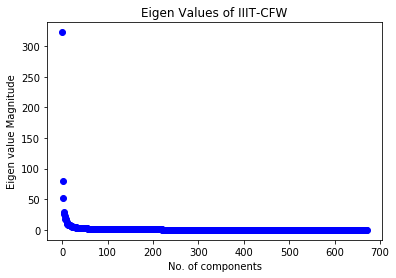

In [278]:
# Plot the eigen value spectrum 
from numpy import linalg as LA
covar1=np.cov(Xf1, rowvar=False)
covar2=np.cov(Xf2, rowvar=False)
covar3=np.cov(Xf3, rowvar=False)
eigv1, ev1= LA.eigh(covar1)
eigv2, ev2= LA.eigh(covar2)
eigv3, ev3= LA.eigh(covar3)
plt.plot(eigv1[::-1],'bo')
plt.xlabel('No. of components')
plt.ylabel('Eigen value Magnitude')
plt.title('Eigen Values of IMFDB')
plt.show()
plt.plot(eigv2[::-1],'bo')
plt.xlabel('No. of components')
plt.ylabel('Eigen value Magnitude')
plt.title('Eigen Values of Yale Face Dataset')
plt.show()
plt.plot(eigv3[::-1],'bo')
plt.xlabel('No. of components')
plt.ylabel('Eigen value Magnitude')
plt.title('Eigen Values of IIIT-CFW')
plt.show()

In [279]:
def components(e):
    a=0
    tot=np.sum(e)
    for i in range(len(e)):
        a=a+e[i]
        if a>= 0.95*tot:
            return i
print('The number of components required for 95 percent feature retention for IMFDB:', components(eigv1[::-1]))
print('The number of components required for 95 percent feature retention for Yale:', components(eigv2[::-1]))
print('The number of components required for 95 percent feature retention for IIIT-CFW:', components(eigv3[::-1]))

The number of components required for 95 percent feature retention for IMFDB: 128
The number of components required for 95 percent feature retention for Yale: 65
The number of components required for 95 percent feature retention for IIIT-CFW: 360


1(c). Reconstruct  the  image  back for each case


In [280]:
def reconstruct_images(k1,k2,k3,feature):
    """
        Reconstruct the images back by just using the selected principal components. 


        You have to write the code in this code block.
        You can change the functions provided above (eg, get_pca, get_lda) for your use case. 
            
        @params: 
                Input parameters

        @return reconstructed_X => reconstructed image
        
    """
    
    Xrecons_IMFDB=((get_pca(X,k1)[1]-np.amin(get_pca(X,k1)[1]))/np.ptp(get_pca(X,k1)[1])).reshape((N,H,W,C))
    Xrecons_Yale=((get_pca(X2,k2)[1]-np.amin(get_pca(X2,k2)[1]))/np.ptp(get_pca(X2,k2)[1])).reshape((N2,H2,W2,C2))
    Xrecons_IIIT_CFW=((get_pca(X3,k3)[1]-np.amin(get_pca(X3,k3)[1]))/np.ptp(get_pca(X3,k3)[1])).reshape((N3,H3,W3,C3))
    
        
    return (Xrecons_IMFDB,Xrecons_Yale,Xrecons_IIIT_CFW)

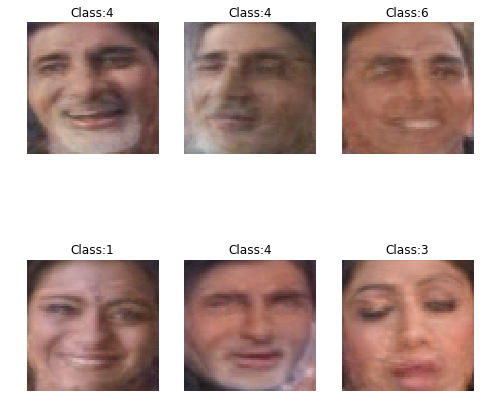

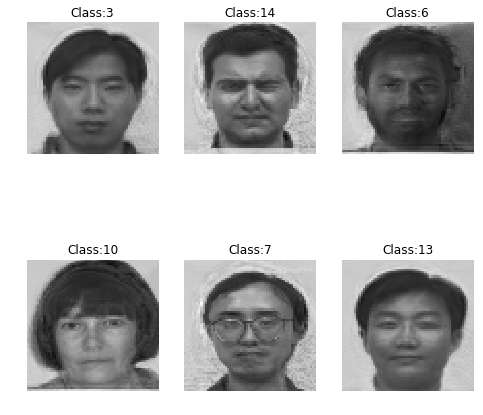

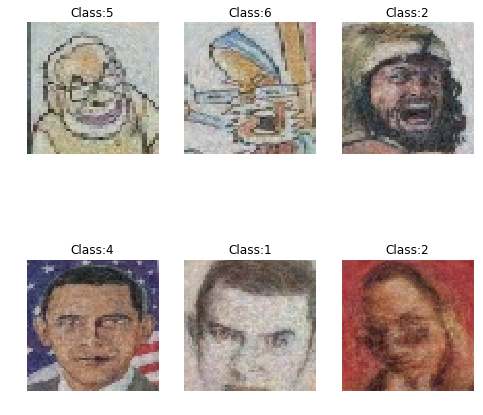

Reconstruction Error for PCA of IMFDB 0.0388237582892
Reconstruction Error for PCA of Yale Face Database 0.0542828700938
Reconstruction Error for PCA of IIIT-CFW 0.0685975771594


In [281]:
# Display results and error
def result_recons(feature,k1,k2,k3):
    recons=reconstruct_images(k1,k2,k3,feature)
    ind = np.random.randint(0,y.shape[0],6)
    disply_images(recons[0][ind,...],y[ind],row=2,col=3,w=W,h=H)
    ind1 = np.random.randint(0,y2.shape[0],6)
    disply_images(recons[1][ind1,...],y2[ind1],row=2,col=3,w=W2,h=H2)
    ind2 = np.random.randint(0,y3.shape[0],6)
    disply_images(recons[2][ind2,...],y3[ind2],row=2,col=3,w=W3,h=H3)
    print('Reconstruction Error for '+ feature+ ' of IMFDB',np.sqrt(np.mean((X - get_pca(X,128)[1])**2)))
    print('Reconstruction Error for '+ feature + ' of Yale Face Database',np.sqrt(np.mean((X2 - get_pca(X2,65)[1])**2)))
    print('Reconstruction Error for '+feature+ ' of IIIT-CFW',np.sqrt(np.mean((X3 - get_pca(X3,360)[1])**2)))
result_recons('PCA',128,65,360)

1(d). Which person/identity is difficult to represent com-pactly with fewer eigen vectors?  Why is that?  Explain with your empirical observations and intuitive answers

In [282]:
# code goes here
def Error(mat,label,k):
    error=[]
    for i in range(8):
        error.append(np.sqrt(np.mean((mat[label==i] - get_pca(mat,k)[1][label==i])**2)))
    e=np.array(error)
    return (e[np.argmax(e)],np.argmax(e))
r1=Error(X,y,128)
r2=Error(X3,y3,360)
error=[]
for i in range(15):
    error.append(np.sqrt(np.mean((X2[y2==i] - get_pca(X2,65)[1][y2==i])**2)))
e=np.array(error)
print('Difficult to represent Class ',r1[1], ' of IMFDB and error is', r1[0])
print('Difficult to represent Class ',np.argmax(e), ' of Yale Face Dataset and error is', e[np.argmax(e)])
print('Difficult to represent Class ',r2[1], ' of IIIT-CFW and error is', r2[0])

Difficult to represent Class  2  of IMFDB and error is 0.040410486251
Difficult to represent Class  0  of Yale Face Dataset and error is 0.0583441645568
Difficult to represent Class  2  of IIIT-CFW and error is 0.073352458412


2(a). Use any classifier(MLP, Logistic regression, SVM, Decision Trees) and find the classification accuracy. 

2(b)Which method works well? Do a comparitivestudy. 


You already know the paper [Face Recognition Us-ing  Kernel  Methods](!http://face-rec.org/algorithms/Kernel/nips01.pdf) .See  this  as  an  example for empirical analysis of different features/classification.

In [283]:
# Define your classifier here. You can use libraries like sklearn to create your classifier 
class Classifier():
    def __init__(self):
        self.mlp=MLPClassifier(hidden_layer_sizes=(1000,1000),max_iter=1000,solver='adam',activation='relu')
        
    def classify(self,X):
        """
            Given an input X classify it into appropriate class. 
        """
        prediction=self.mlp.predict(X)
        return prediction
        
    def confusion_matrix(self,pred,y):
        """
            A confusion matrix is a table that is often used to describe the performance of a classification
            model (or “classifier”) on a set of test data for which the true values are known.
            
            
            @return confusion_matrix => num_classesxnum_classes martix 
                where confusion_matrix[i,j] = number of prediction which are i and number of ground truth value equal j 
        
        """
        cm=confusion_matrix(y,pred)
        return cm
        
    def train(self,X_train,y_train):
        """
            Given your training data, learn the parameters of your classifier
            
            @param X_train => NxD tensor. Where N is the number of samples and D is the dimension. 
                                it is the data on which your classifier will be trained. 
                                It can be any combination of features provided above.

            @param y_train => N vector. Ground truth label 
    
            @return Nothing
        """
        self.mlp.fit(X_train,y_train)

    def validate(self,X_validate,y_validate):
        """
            How good is the classifier on unseen data? Use the function below to calculate different metrics. 
            Based on these matrix change the hyperparmeters and judge the classification
            
            @param X_validate => NxD tensor. Where N is the number of samples and D is the dimension. 
                                it is the data on which your classifier validated. 
                                It can be any combination of features provided above.

            @param y_validate => N vector. Ground truth label 
            
        """
        pred=self.classify(X_validate)
        # Create a confusion matrix
        cm=self.confusion_matrix(pred,y_validate)
        
        # Calculate Validation accuracy 
        acc=self.mlp.score(X_validate,y_validate)
    
        # Calculate precision and recall 
        prec=precision_score(y_validate, pred, average='macro')
        recall=recall_score(y_validate, pred, average='macro')
        # Calculate F1-score
        f1=f1_score(y_validate, pred, average='macro')
        
        return (cm,acc,f1) 

In [284]:
X_train1, X_validate1, y_train1, y_validate1 = train_test_split(X, y, test_size=0.2, random_state=42)
X_t1, X_v1, y_t1, y_v1 = train_test_split(get_vgg_features('./dataset/IMFDB/'), y, test_size=0.2, random_state=42)
X_t2, X_v2, y_t2, y_v2 = train_test_split(get_resnet_features('./dataset/IMFDB/'), y, test_size=0.2, random_state=42)
matrix_train_1=[get_pca(X_train1,128)[0],\
                get_kernel_pca(X_train1,128,X_validate1)[0],\
               get_lda(X_train1,y_train1,X_validate1)[0],\
               get_kernel_lda(X_train1,y_train1,X_validate1)[0],\
               X_t1,\
                X_t2,\
               get_lda(X_t1,y_t1,X_v1)[0],\
                get_lda(X_t2,y_t2,X_v2)[0],\
               get_pca(X_t2,200)[0],\
                get_pca(X_t1,200)[0]]
matrix_test_1=[get_pca(X_train1,128)[2].transform(X_validate1),get_kernel_pca(X_train1,128,X_validate1)[1],\
               get_lda(X_train1,y_train1,X_validate1)[1],\
               get_kernel_lda(X_train1,y_train1,X_validate1)[1],\
               X_v1,X_v2,\
               get_lda(X_t1,y_t1,X_v1)[1], get_lda(X_t2,y_t2,X_v2)[1],\
               get_pca(X_t2,200)[2].transform(X_v2),get_pca(X_t1,200)[2].transform(X_v1)]
name=['PCA', 'Kernel PCA', 'LDA','Kernal LDA','VGG','Resnet', 'LDA + VGG', 'LDA + Resnet', 'PCA + Resnet', 'PCA + VGG']
data1=[]
cm1=[]
for i in range(len(matrix_train_1)):
    c=Classifier()
    table1=[]
    if i==4 or i==6 or i==9:
        c.train(matrix_train_1[i],y_t1)
        cm,acc,f1=c.validate(matrix_test_1[i],y_v1)
    if i==5 or i==7 or i==8:
        c.train(matrix_train_1[i],y_t2)
        cm,acc,f1=c.validate(matrix_test_1[i],y_v2)
    else:
        c.train(matrix_train_1[i],y_train1)
        cm,acc,f1=c.validate(matrix_test_1[i],y_validate1)
    table1.append(name[i])
    table1.append(matrix_test_1[i].shape[1])
    table1.append((1-acc)*100)
    table1.append(acc*100)
    table1.append(f1)
    data1.append(table1)
    cm1.append(cm)
    
df1 = pd.DataFrame(data1, columns = ['Feature', 'Dimension','Error','Accuracy','F1-score'])
print(df1)

        Feature  Dimension  Error  Accuracy  F1-score
0           PCA        128  12.50     87.50  0.868291
1    Kernel PCA        128  11.25     88.75  0.884942
2           LDA          7  21.25     78.75  0.789493
3    Kernal LDA          7  22.50     77.50  0.778921
4           VGG       4096  10.00     90.00  0.893398
5        Resnet       2048   5.00     95.00  0.945486
6     LDA + VGG          7  35.00     65.00  0.629857
7  LDA + Resnet          7   3.75     96.25  0.964451
8  PCA + Resnet        200   3.75     96.25  0.957629
9     PCA + VGG        200  11.25     88.75  0.887446


In [285]:
X_train2, X_validate2, y_train2, y_validate2 = train_test_split(X2, y2, test_size=0.2, random_state=42)
X_t12, X_v12, y_t12, y_v12 = train_test_split(get_vgg_features('./dataset/Yale_face_database/'), y2, test_size=0.2, random_state=42)
X_t22, X_v22, y_t22, y_v22 = train_test_split(get_resnet_features('./dataset/Yale_face_database/'), y2, test_size=0.2, random_state=42)
matrix_train_2=[get_pca(X_train2,65)[0],\
                get_kernel_pca(X_train2,65,X_validate2)[0],\
               get_lda(X_train2,y_train2,X_validate2,15)[0],\
               get_kernel_lda(X_train2,y_train2,X_validate2,15)[0],\
               X_t12,\
                X_t22,\
               get_lda(X_t12,y_t12,X_v12,15)[0],\
                get_lda(X_t22,y_t22,X_v22,15)[0],\
               get_pca(X_t22,80)[0],\
                get_pca(X_t12,80)[0]]
matrix_test_2=[get_pca(X_train2,65)[2].transform(X_validate2),get_kernel_pca(X_train2,65,X_validate2)[1],\
               get_lda(X_train2,y_train2,X_validate2,15)[1],\
               get_kernel_lda(X_train2,y_train2,X_validate2,15)[1],\
               X_v12,X_v22,\
               get_lda(X_t12,y_t12,X_v12,15)[1], get_lda(X_t22,y_t22,X_v22,15)[1],\
               get_pca(X_t22,80)[2].transform(X_v22),get_pca(X_t12,80)[2].transform(X_v12)]
data2=[]
cm2=[]
for i in range(len(matrix_train_2)):
    c=Classifier()
    table1=[]
    if i==4 or i==6 or i==9:
        c.train(matrix_train_2[i],y_t12)
        cm,acc,f1=c.validate(matrix_test_2[i],y_v12)
    if i==5 or i==7 or i==8:
        c.train(matrix_train_2[i],y_t22)
        cm,acc,f1=c.validate(matrix_test_2[i],y_v22)
    else:
        c.train(matrix_train_2[i],y_train2)
        cm,acc,f1=c.validate(matrix_test_2[i],y_validate2)
    table1.append(name[i])
    table1.append(matrix_train_2[i].shape[1])
    table1.append((1-acc)*100)
    table1.append(acc*100)
    table1.append(f1)
    data2.append(table1)
    cm2.append(cm)
    
df2 = pd.DataFrame(data2, columns = ['Feature', 'Dimension','Error','Accuracy','F1-score'])
print(df2)


        Feature  Dimension      Error    Accuracy  F1-score
0           PCA         65  21.212121   78.787879  0.734127
1    Kernel PCA         65  24.242424   75.757576  0.749660
2           LDA         14   0.000000  100.000000  1.000000
3    Kernal LDA         14   0.000000  100.000000  1.000000
4           VGG       4096  42.424242   57.575758  0.460000
5        Resnet       2048   6.060606   93.939394  0.927891
6     LDA + VGG         14  45.454545   54.545455  0.465368
7  LDA + Resnet         14   0.000000  100.000000  1.000000
8  PCA + Resnet         80   3.030303   96.969697  0.952381
9     PCA + VGG         80  48.484848   51.515152  0.437778


In [286]:
X_train3, X_validate3, y_train3, y_validate3 = train_test_split(X3, y3, test_size=0.2, random_state=42)
X_t13, X_v13, y_t13, y_v13 = train_test_split(get_vgg_features('./dataset/IIIT-CFW/'), y3, test_size=0.2, random_state=42)
X_t23, X_v23, y_t23, y_v23 = train_test_split(get_resnet_features('./dataset/IIIT-CFW/'), y3, test_size=0.2, random_state=42)
matrix_train_3=[get_pca(X_train3,360)[0],\
                get_kernel_pca(X_train3,360,X_validate3)[0],\
               get_lda(X_train3,y_train3,X_validate3)[0],\
               get_kernel_lda(X_train3,y_train3,X_validate3)[0],\
               X_t13,\
                X_t23,\
               get_lda(X_t13,y_t13,X_v13)[0],\
                get_lda(X_t23,y_t23,X_v23)[0],\
               get_pca(X_t23,300)[0],\
                get_pca(X_t13,300)[0]]
matrix_test_3=[get_pca(X_train3,360)[2].transform(X_validate3),get_kernel_pca(X_train3,360,X_validate3)[1],\
               get_lda(X_train3,y_train3,X_validate3)[1],\
               get_kernel_lda(X_train3,y_train3,X_validate3)[1],\
               X_v13,X_v23,\
               get_lda(X_t13,y_t13,X_v13)[1], get_lda(X_t23,y_t23,X_v23)[1],\
               get_pca(X_t23,300)[2].transform(X_v23),get_pca(X_t13,300)[2].transform(X_v13)]
data3=[]
cm3=[]
for i in range(len(matrix_train_3)):
    c=Classifier()
    table1=[]
    if i==4 or i==6 or i==9:
        c.train(matrix_train_3[i],y_t13)
        cm,acc,f1=c.validate(matrix_test_3[i],y_v13)
    if i==5 or i==7 or i==8:
        c.train(matrix_train_3[i],y_t23)
        cm,acc,f1=c.validate(matrix_test_3[i],y_v23)
    else:
        c.train(matrix_train_3[i],y_train3)
        cm,acc,f1=c.validate(matrix_test_3[i],y_validate3)
    table1.append(name[i])
    table1.append(matrix_train_3[i].shape[1])
    table1.append((1-acc)*100)
    table1.append(acc*100)
    table1.append(f1)
    data3.append(table1)
    cm3.append(cm)
    
df3 = pd.DataFrame(data3, columns = ['Feature', 'Dimension','Error','Accuracy','F1-score'])
print(df3)

        Feature  Dimension      Error   Accuracy  F1-score
0           PCA        360  39.259259  60.740741  0.601010
1    Kernel PCA        360  42.962963  57.037037  0.579169
2           LDA          7  61.481481  38.518519  0.379192
3    Kernal LDA          7  60.740741  39.259259  0.382475
4           VGG       4096  29.629630  70.370370  0.661468
5        Resnet       2048   2.962963  97.037037  0.968275
6     LDA + VGG          7  40.000000  60.000000  0.528417
7  LDA + Resnet          7   2.962963  97.037037  0.972103
8  PCA + Resnet        300   2.222222  97.777778  0.979284
9     PCA + VGG        300  32.592593  67.407407  0.638620


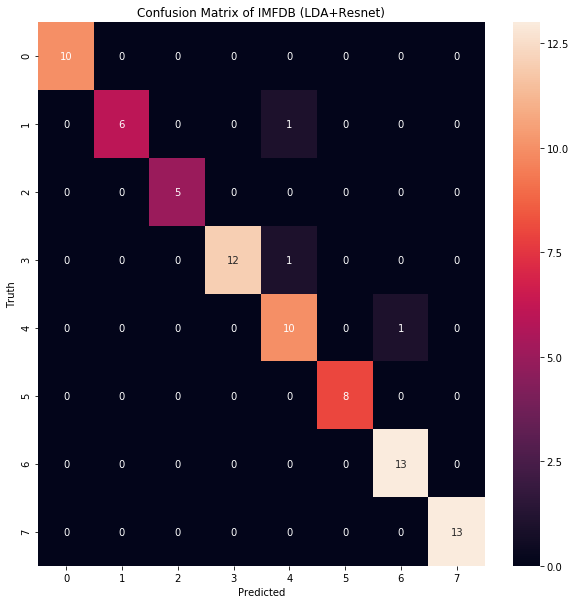

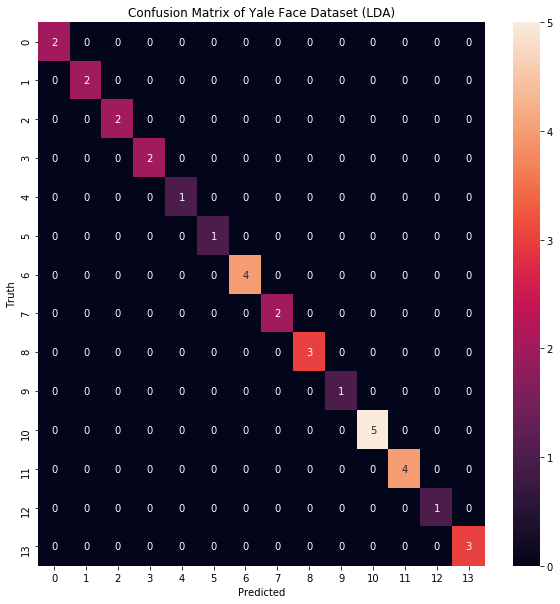

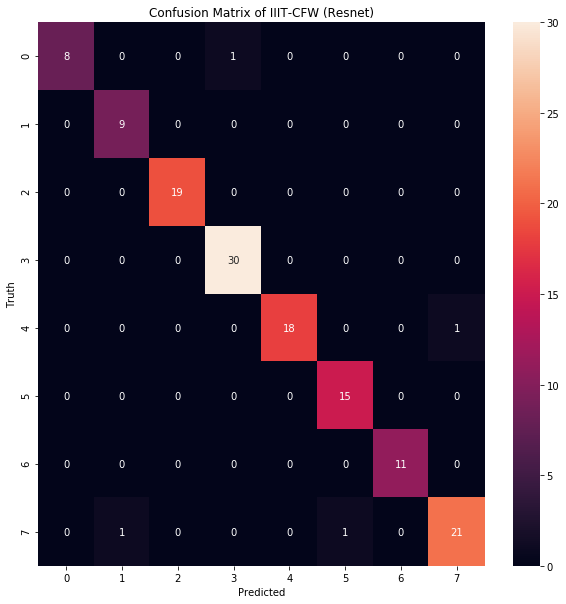

In [287]:
plt.figure(figsize = (10,10))
sn.heatmap(cm1[7], annot = True)
plt.title('Confusion Matrix of IMFDB (LDA+Resnet)')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()
plt.figure(figsize = (10,10))
sn.heatmap(cm2[2], annot = True)
plt.title('Confusion Matrix of Yale Face Dataset (LDA)')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()
plt.figure(figsize = (10,10))
sn.heatmap(cm3[5], annot = True)
plt.title('Confusion Matrix of IIIT-CFW (Resnet)')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

3. Similiar to 1(b) use t-SNE based visilization of faces?  Does it makesense?  Do you see similar people coming together?or something else?  Can you do visualization datasetwise and combined? Here you will use a popular implementation.(Worth  reading and understanding  t-SNE.  We  will not discuss it in the class and out of scope for thiscourse/exams.

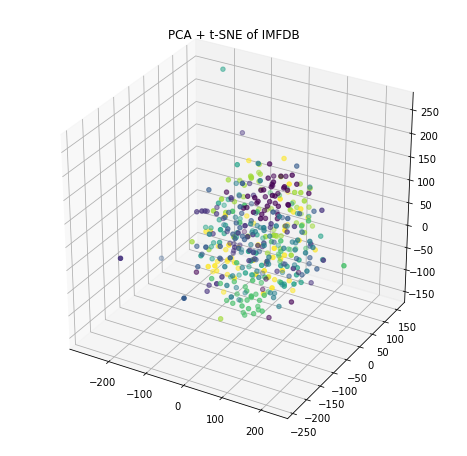

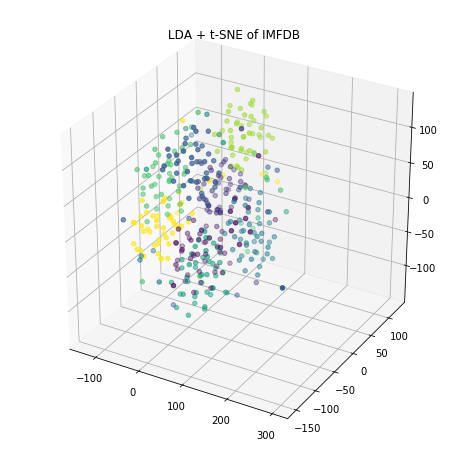

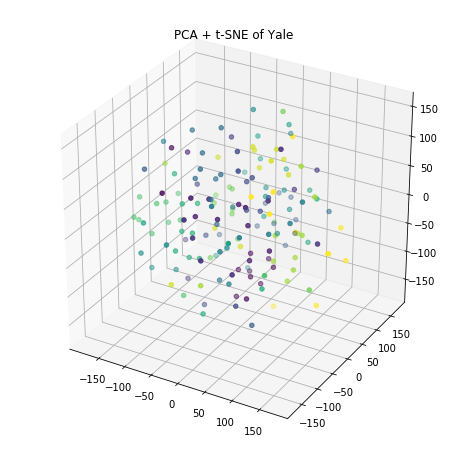

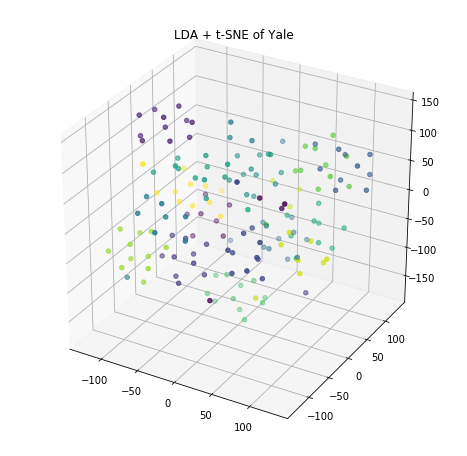

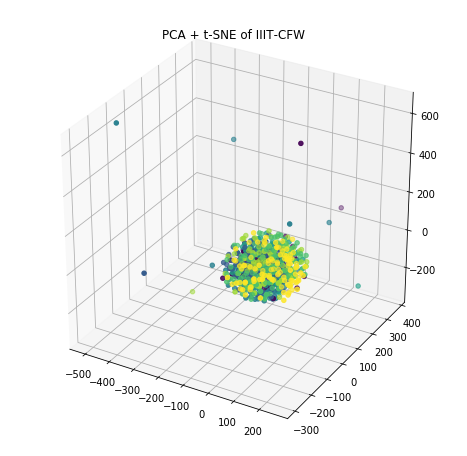

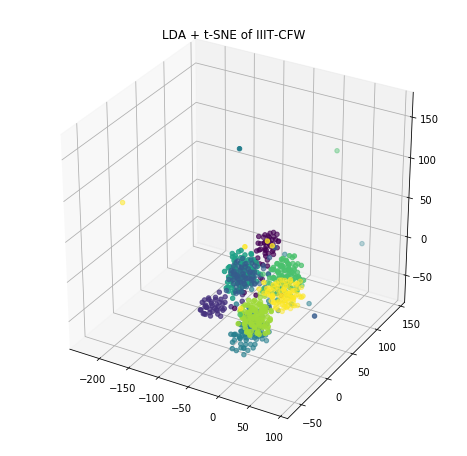

In [288]:
# Compute TSNE for different features and create a scatter plot
def sne(data,label,k1,k2,dataset):
    X1=get_pca(data,k1)[0]
    X_TSNE1 = TSNE(n_components=3).fit_transform(X1)
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111, projection='3d')
    plt.title('PCA + t-SNE of ' + dataset)
    ax.scatter(X_TSNE1[:,0],X_TSNE1[:,1],X_TSNE1[:,2],c=label)
    plt.show()
    X2=get_lda(data,label,k2)[0]
    X_TSNE2 = TSNE(n_components=3).fit_transform(X2)
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111, projection='3d')
    plt.title('LDA + t-SNE of ' + dataset)
    ax.scatter(X_TSNE2[:,0],X_TSNE2[:,1],X_TSNE2[:,2],c=label)
    plt.show()
sne(X,y,128,7,'IMFDB')
sne(X2,y2,65,15,'Yale')
sne(X3,y3,360,7,'IIIT-CFW')

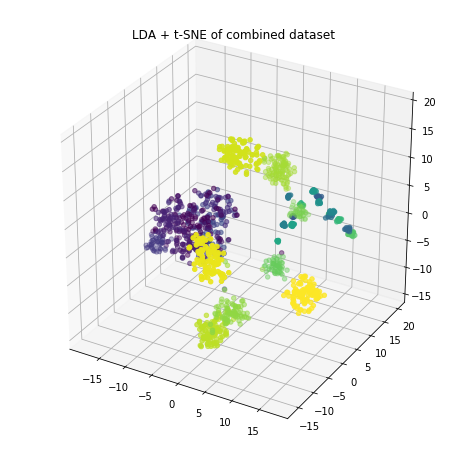

In [289]:
concatenate=np.vstack((X,X2,X3))
label = np.vstack((y.reshape(400,1),(y2+8).reshape(165,1),(y3+15+8).reshape(672,1)))
label=label.reshape(1237)
X_c=get_lda(concatenate,label,30)[0]
X_TSNE2 = TSNE(n_components=3).fit_transform(X_c)
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
plt.title('LDA + t-SNE of combined dataset')
ax.scatter(X_TSNE2[:,0],X_TSNE2[:,1],X_TSNE2[:,2],c=label)
plt.show()

4.`face`  is  used  for  verification.   

4(a) How do we formulate the problem using KNN 

4(b) How do we analyze the performance ? suggest  the  metrics  (like  accuracy) that is appropriate for this task.

_______________________________________________________________________

4(c)Show empirical re-sults  with  all  the  representations

In [290]:
class FaceVerification():
    def __init__(self,k):
        self.nn=KNeighborsClassifier(n_neighbors=k)
    def verify(self,X,class_id=None):
        """
            Given an input X find if the class id is correct or not.
            
            @return verfication_results => N vector containing True or False. 
                    If the class-id matches with your prediction then true else false.   
        """

        pred=self.nn.predict(X)
        return pred
        
    def train(self,X_train,y_train):
        """
            Given your training data, learn the parameters of your classifier
            
            @param X_train => NxD tensor. Where N is the number of samples and D is the dimension. 
                                it is the data on which your verification system will be trained. 
                                It can be any combination of features provided above.

            @param y_train => N vector. Ground truth label 
    
            @return Nothing
        """
        self.nn.fit(X_train,y_train)
    def validate(self,X_validate,y_validate):
        """
            How good is your system on unseen data? Use the function below to calculate different metrics. 
            Based on these matrix change the hyperparmeters
            
            @param X_validate => NxD tensor. Where N is the number of samples and D is the dimension. 
                                It can be any combination of features provided above.

            @param y_validate => N vector. Ground truth label 
            
        """
        pred=self.verify(X_validate)
        
        # Calculate Validation accuracy 
        acc=self.nn.score(X_validate,y_validate)
    
        # Calculate precision 
        prec=precision_score(y_validate, pred, average='macro')
        return (acc,prec)

In [291]:
X_train1, X_validate1, y_train1, y_validate1 = train_test_split(X, y, test_size=0.2, random_state=42)
X_t1, X_v1, y_t1, y_v1 = train_test_split(get_vgg_features('./dataset/IMFDB/'), y, test_size=0.2, random_state=42)
X_t2, X_v2, y_t2, y_v2 = train_test_split(get_resnet_features('./dataset/IMFDB/'), y, test_size=0.2, random_state=42)
matrix_train_1=[get_pca(X_train1,128)[0],\
                get_kernel_pca(X_train1,128,X_validate1)[0],\
               get_lda(X_train1,y_train1,X_validate1)[0],\
               get_kernel_lda(X_train1,y_train1,X_validate1)[0],\
               X_t1,\
                X_t2,\
               get_lda(X_t1,y_t1,X_v1)[0],\
                get_lda(X_t2,y_t2,X_v2)[0],\
               get_pca(X_t2,200)[0],\
                get_pca(X_t1,200)[0]]
matrix_test_1=[get_pca(X_train1,128)[2].transform(X_validate1),get_kernel_pca(X_train1,128,X_validate1)[1],\
               get_lda(X_train1,y_train1,X_validate1)[1],\
               get_kernel_lda(X_train1,y_train1,X_validate1)[1],\
               X_v1,X_v2,\
               get_lda(X_t1,y_t1,X_v1)[1], get_lda(X_t2,y_t2,X_v2)[1],\
               get_pca(X_t2,200)[2].transform(X_v2),get_pca(X_t1,200)[2].transform(X_v1)]
name=['PCA', 'Kernel PCA', 'LDA','Kernal LDA','VGG','Resnet', 'LDA + VGG', 'LDA + Resnet', 'PCA + Resnet', 'PCA + VGG']
data1=[]
for i in range(len(matrix_train_1)):
    c=FaceVerification(5)
    table1=[]
    if i==4 or i==6 or i==9:
        c.train(matrix_train_1[i],y_t1)
        acc,pc=c.validate(matrix_test_1[i],y_v1)
    if i==5 or i==7 or i==8:
        c.train(matrix_train_1[i],y_t2)
        acc,pc=c.validate(matrix_test_1[i],y_v2)
    else:
        c.train(matrix_train_1[i],y_train1)
        acc,pc=c.validate(matrix_test_1[i],y_validate1)
    table1.append(name[i])
    table1.append(matrix_test_1[i].shape[1])
    table1.append((1-acc)*100)
    table1.append(acc*100)
    table1.append(pc)
    data1.append(table1)
    
df1 = pd.DataFrame(data1, columns = ['Feature', 'Dimension','Error','Accuracy','Precision'])
print(df1)

        Feature  Dimension  Error  Accuracy  Precision
0           PCA        128  43.75     56.25   0.674929
1    Kernel PCA        128  45.00     55.00   0.680060
2           LDA          7  18.75     81.25   0.821479
3    Kernal LDA          7  18.75     81.25   0.821479
4           VGG       4096  11.25     88.75   0.879132
5        Resnet       2048   6.25     93.75   0.938636
6     LDA + VGG          7  27.50     72.50   0.722727
7  LDA + Resnet          7   6.25     93.75   0.944643
8  PCA + Resnet        200   6.25     93.75   0.937354
9     PCA + VGG        200  11.25     88.75   0.879132


In [292]:
k=[4,6,7,10]
d1=[]
for i in range(len(k)):
    table1=[]
    c=FaceVerification(k[i])
    c.train(X_t2,y_t2)
    acc,pc=c.validate(X_v2,y_v2)
    table1.append('Resnet')
    table1.append(k[i])
    table1.append(X_t2.shape[1])
    table1.append((1-acc)*100)
    table1.append(acc*100)
    table1.append(pc)
    d1.append(table1)
df1 = pd.DataFrame(d1, columns = ['Feature', 'K','Dimension','Error','Accuracy','Precision'])
print(df1)  

  Feature   K  Dimension  Error  Accuracy  Precision
0  Resnet   4       2048   6.25     93.75   0.938636
1  Resnet   6       2048   6.25     93.75   0.937354
2  Resnet   7       2048   6.25     93.75   0.937354
3  Resnet  10       2048   5.00     95.00   0.954545


In [293]:
X_train2, X_validate2, y_train2, y_validate2 = train_test_split(X2, y2, test_size=0.2, random_state=42)
X_t12, X_v12, y_t12, y_v12 = train_test_split(get_vgg_features('./dataset/Yale_face_database/'), y2, test_size=0.2, random_state=42)
X_t22, X_v22, y_t22, y_v22 = train_test_split(get_resnet_features('./dataset/Yale_face_database/'), y2, test_size=0.2, random_state=42)
matrix_train_2=[get_pca(X_train2,65)[0],\
                get_kernel_pca(X_train2,65,X_validate2)[0],\
               get_lda(X_train2,y_train2,X_validate2,15)[0],\
               get_kernel_lda(X_train2,y_train2,X_validate2,15)[0],\
               X_t12,\
                X_t22,\
               get_lda(X_t12,y_t12,X_v12,15)[0],\
                get_lda(X_t22,y_t22,X_v22,15)[0],\
               get_pca(X_t22,80)[0],\
                get_pca(X_t12,80)[0]]
matrix_test_2=[get_pca(X_train2,65)[2].transform(X_validate2),get_kernel_pca(X_train2,65,X_validate2)[1],\
               get_lda(X_train2,y_train2,X_validate2,15)[1],\
               get_kernel_lda(X_train2,y_train2,X_validate2,15)[1],\
               X_v12,X_v22,\
               get_lda(X_t12,y_t12,X_v12,15)[1], get_lda(X_t22,y_t22,X_v22,15)[1],\
               get_pca(X_t22,80)[2].transform(X_v22),get_pca(X_t12,80)[2].transform(X_v12)]
data2=[]
for i in range(len(matrix_train_2)):
    c=FaceVerification(5)
    table1=[]
    if i==4 or i==6 or i==9:
        c.train(matrix_train_2[i],y_t12)
        acc,pc=c.validate(matrix_test_2[i],y_v12)
    if i==5 or i==7 or i==8:
        c.train(matrix_train_2[i],y_t22)
        acc,pc=c.validate(matrix_test_2[i],y_v22)
    else:
        c.train(matrix_train_2[i],y_train2)
        acc,pc=c.validate(matrix_test_2[i],y_validate2)
    table1.append(name[i])
    table1.append(matrix_train_2[i].shape[1])
    table1.append((1-acc)*100)
    table1.append(acc*100)
    table1.append(pc)
    data2.append(table1)
    
df2 = pd.DataFrame(data2, columns = ['Feature', 'Dimension','Error','Accuracy','Precision'])
print(df2)


        Feature  Dimension      Error    Accuracy  Precision
0           PCA         65  27.272727   72.727273   0.707143
1    Kernel PCA         65  24.242424   75.757576   0.730952
2           LDA         14   3.030303   96.969697   0.964286
3    Kernal LDA         14   3.030303   96.969697   0.964286
4           VGG       4096  48.484848   51.515152   0.413333
5        Resnet       2048   0.000000  100.000000   1.000000
6     LDA + VGG         14  45.454545   54.545455   0.462222
7  LDA + Resnet         14   3.030303   96.969697   0.964286
8  PCA + Resnet         80   0.000000  100.000000   1.000000
9     PCA + VGG         80  48.484848   51.515152   0.413333


In [294]:
k1=[4,6,7,10]
d2=[]
for i in range(len(k1)):
    table1=[]
    c=FaceVerification(k1[i])
    c.train(X_t22,y_t22)
    acc,pc=c.validate(X_v22,y_v22)
    table1.append('Resnet')
    table1.append(k1[i])
    table1.append(X_t22.shape[1])
    table1.append((1-acc)*100)
    table1.append(acc*100)
    table1.append(pc)
    d2.append(table1)
df1 = pd.DataFrame(d2, columns = ['Feature', 'K','Dimension','Error','Accuracy','Precision'])
print(df1)  

  Feature   K  Dimension     Error    Accuracy  Precision
0  Resnet   4       2048  3.030303   96.969697    0.97619
1  Resnet   6       2048  0.000000  100.000000    1.00000
2  Resnet   7       2048  0.000000  100.000000    1.00000
3  Resnet  10       2048  0.000000  100.000000    1.00000


In [295]:
X_train3, X_validate3, y_train3, y_validate3 = train_test_split(X3, y3, test_size=0.2, random_state=42)
X_t13, X_v13, y_t13, y_v13 = train_test_split(get_vgg_features('./dataset/IIIT-CFW/'), y3, test_size=0.2, random_state=42)
X_t23, X_v23, y_t23, y_v23 = train_test_split(get_resnet_features('./dataset/IIIT-CFW/'), y3, test_size=0.2, random_state=42)
matrix_train_3=[get_pca(X_train3,360)[0],\
                get_kernel_pca(X_train3,360,X_validate3)[0],\
               get_lda(X_train3,y_train3,X_validate3)[0],\
               get_kernel_lda(X_train3,y_train3,X_validate3)[0],\
               X_t13,\
                X_t23,\
               get_lda(X_t13,y_t13,X_v13)[0],\
                get_lda(X_t23,y_t23,X_v23)[0],\
               get_pca(X_t23,300)[0],\
                get_pca(X_t13,300)[0]]
matrix_test_3=[get_pca(X_train3,360)[2].transform(X_validate3),get_kernel_pca(X_train3,360,X_validate3)[1],\
               get_lda(X_train3,y_train3,X_validate3)[1],\
               get_kernel_lda(X_train3,y_train3,X_validate3)[1],\
               X_v13,X_v23,\
               get_lda(X_t13,y_t13,X_v13)[1], get_lda(X_t23,y_t23,X_v23)[1],\
               get_pca(X_t23,300)[2].transform(X_v23),get_pca(X_t13,300)[2].transform(X_v13)]
data3=[]
for i in range(len(matrix_train_3)):
    c=FaceVerification(5)
    table1=[]
    if i==4 or i==6 or i==9:
        c.train(matrix_train_3[i],y_t13)
        acc,pc=c.validate(matrix_test_3[i],y_v13)
    if i==5 or i==7 or i==8:
        c.train(matrix_train_3[i],y_t23)
        acc,pc=c.validate(matrix_test_3[i],y_v23)
    else:
        c.train(matrix_train_3[i],y_train3)
        acc,pc=c.validate(matrix_test_3[i],y_validate3)
    table1.append(name[i])
    table1.append(matrix_train_3[i].shape[1])
    table1.append((1-acc)*100)
    table1.append(acc*100)
    table1.append(pc)
    data3.append(table1)
    
df3 = pd.DataFrame(data3, columns = ['Feature', 'Dimension','Error','Accuracy','Precision'])
print(df3)

        Feature  Dimension      Error   Accuracy  Precision
0           PCA        360  69.629630  30.370370   0.345661
1    Kernel PCA        360  69.629630  30.370370   0.353009
2           LDA          7  54.074074  45.925926   0.474348
3    Kernal LDA          7  54.074074  45.925926   0.474348
4           VGG       4096  31.851852  68.148148   0.673355
5        Resnet       2048   2.962963  97.037037   0.973280
6     LDA + VGG          7  36.296296  63.703704   0.567677
7  LDA + Resnet          7   2.962963  97.037037   0.974877
8  PCA + Resnet        300   2.962963  97.037037   0.973280
9     PCA + VGG        300  32.592593  67.407407   0.662257


In [296]:
k3=[4,6,7,10]
d3=[]
for i in range(len(k)):
    table1=[]
    c=FaceVerification(k[i])
    c.train(X_t23,y_t23)
    acc,pc=c.validate(X_v23,y_v23)
    table1.append('Resnet')
    table1.append(k3[i])
    table1.append(X_t23.shape[1])
    table1.append((1-acc)*100)
    table1.append(acc*100)
    table1.append(pc)
    d3.append(table1)
df1 = pd.DataFrame(d3, columns = ['Feature', 'K','Dimension','Error','Accuracy','Precision'])
print(df1)  

  Feature   K  Dimension     Error   Accuracy  Precision
0  Resnet   4       2048  2.962963  97.037037   0.973609
1  Resnet   6       2048  2.962963  97.037037   0.973280
2  Resnet   7       2048  2.962963  97.037037   0.974877
3  Resnet  10       2048  2.222222  97.777778   0.980400


### Extenstion / Application
    Create a system for any one of the following problems:

- Politicians  vs  Filmstars  in  a  public  data  set.   (eg.LFW)
        You already have seen IIIT-CFW dataset. Use it for classification. 
- Age prediction
        Given different actors/actress in IMFDB create new labels based on their age.  
- Gender prediction
        Given different actors/actress in IMFDB+IIIT-CFW create new labels based on their gender.
- Emotion classification
        Both the yale dataset and IMFDB contain an `emotion.txt` file. Using that you can create a emotion predicter 
- cartoon vs real images
        Use a combination of IIIT-CFW and other dataset. 
        


You are free to use a new dataset that is publicly avail-able or even create one by crawling from internet.

In [297]:
# Load data
def l_data(dir_path):
    emotion_dict=dict()
    file = open(dir_path + 'emotion.txt', 'r')
    for line in file:
        line=line.strip()
        fields = line.split(",")
        name = fields[0].split('.')[0]
        emotion = fields[1]
        emotion_dict[name]=emotion 
    image_list = []
    y_list = []
    if "yale" in dir_path.lower():
        label_dict = emotion_dict
    elif "IMFDB" in dir_path:
        label_dict = emotion_dict
    else:
        raise KeyError("Dataset not found.")
    
    
    for filename in sorted(os.listdir(dir_path)):
        if filename.endswith(".png"):
            im = load_image(os.path.join(dir_path,filename))
            y = filename.split('.')[0]
            y = label_dict[y] 
            image_list.append(im)
            y_list.append(y)
        else:
            continue

    image_list = np.array(image_list)
    y_list = np.array(y_list)
    return image_list,y_list
dirpath = './dataset/IMFDB/'
X,y = l_data(dirpath)
N,H,W = X.shape[0:3]
C = 1 if opt['is_grayscale'] else X.shape[3]
X=X.reshape((N,H*W*C))
print(X.shape)
dirpath1 = './dataset/Yale_face_database/'
X1,y1 = l_data(dirpath1)
N1,H1,W1 = X1.shape[0:3]
C1 = 1 if opt['is_grayscale'] else X1.shape[3]
X1=X1.reshape((N1,H1*W1*C1))
print(X1.shape)
l1=preprocessing.LabelEncoder()
l1.fit(np.unique(y))
y_enc = l1.transform(y)
l2=preprocessing.LabelEncoder()
l2.fit(np.unique(y1))
y_enc_1=l2.transform(y1)

(400, 12288)
(165, 12288)


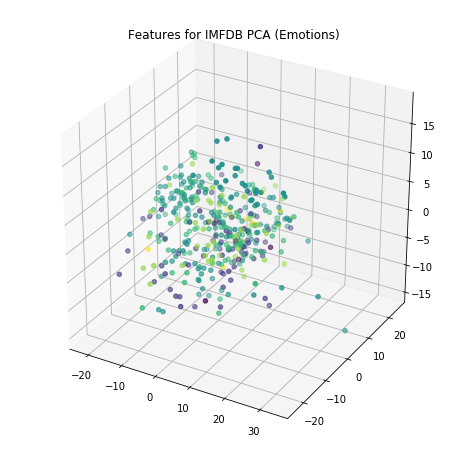

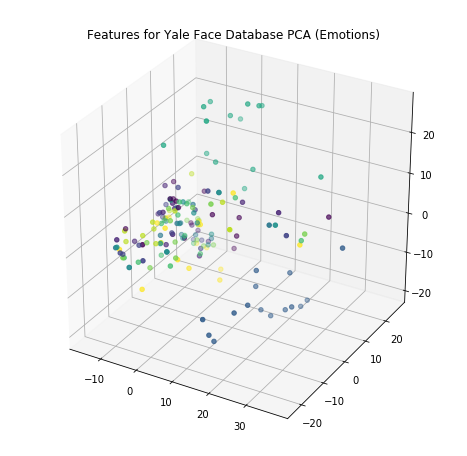

In [298]:
#PCA
Xf1=get_pca(X,128)[0]
Xf2=get_pca(X1,65)[0]
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
plt.title('Features for IMFDB PCA (Emotions)')
ax.scatter(Xf1[:,0],Xf1[:,1],Xf1[:,2],c=y_enc)
plt.show()
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
plt.title('Features for Yale Face Database PCA (Emotions)')
ax.scatter(Xf2[:,0],Xf2[:,1],Xf2[:,2],c=y_enc_1)
plt.show()

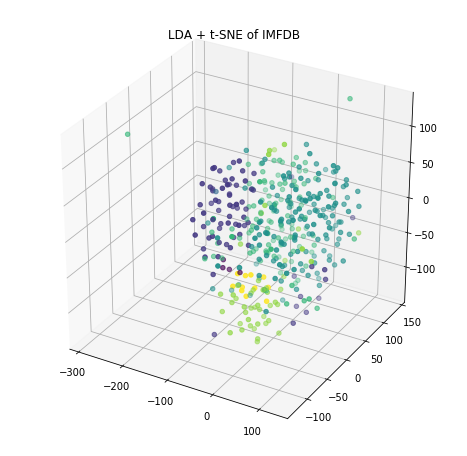

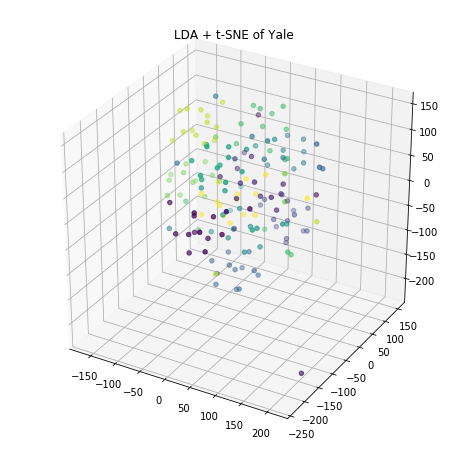

In [299]:
#TSNE
def sne(data,label,k,dataset):
    X=get_lda(data,label,k)[0]
    X_TSNE1 = TSNE(n_components=3).fit_transform(X)
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111, projection='3d')
    plt.title('LDA + t-SNE of ' + dataset)
    ax.scatter(X_TSNE1[:,0],X_TSNE1[:,1],X_TSNE1[:,2],c=label)
    plt.show()
sne(X,y_enc,6,'IMFDB')
sne(X1,y_enc_1,10,'Yale')

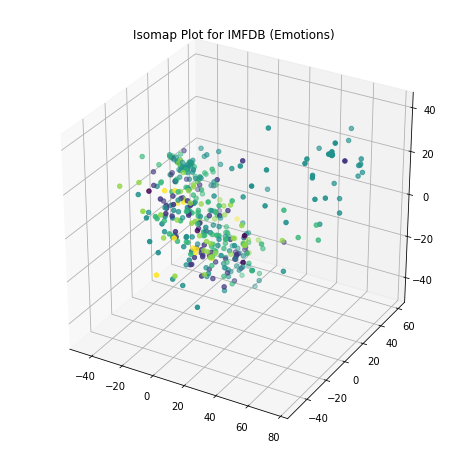

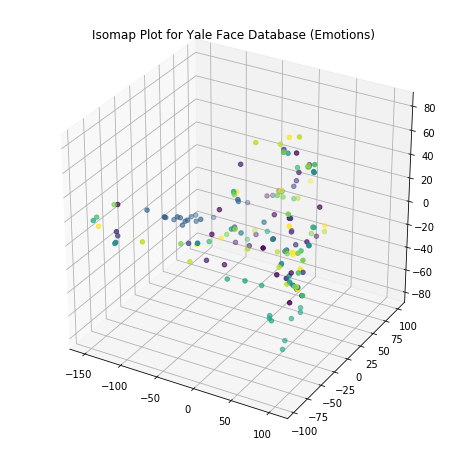

In [300]:
#Isomap
I=Isomap(n_components=3)
Xi1=I.fit_transform(X)
Xi2=I.fit_transform(X1)
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
plt.title('Isomap Plot for IMFDB (Emotions)')
ax.scatter(Xi1[:,0],Xi1[:,1],Xi1[:,2],c=y_enc)
plt.show()
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
plt.title('Isomap Plot for Yale Face Database (Emotions)')
ax.scatter(Xi2[:,0],Xi2[:,1],Xi2[:,2],c=y_enc_1)
plt.show()

In [301]:
# Define your classifier here. You can use libraries like sklearn to create your classifier 
class LR():
    def __init__(self):
        self.lr=LogisticRegression(C=0.01)
    def classify(self,X):
        prediction=self.lr.predict(X)
        return prediction
    def train(self,X_train,y_train):
        self.lr.fit(X_train,y_train)
    def validate(self,X_validate,y_validate):
        pred=self.classify(X_validate)
        acc=self.lr.score(X_validate,y_validate)
        prec=precision_score(y_validate, pred, average='macro')
        return (acc,prec) 

In [302]:
X_train1, X_validate1, y_train1, y_validate1 = train_test_split(X, y_enc, test_size=0.2, random_state=42)
X_t1, X_v1, y_t1, y_v1 = train_test_split(get_vgg_features('./dataset/IMFDB/'), y_enc, test_size=0.2, random_state=42)
X_t2, X_v2, y_t2, y_v2 = train_test_split(get_resnet_features('./dataset/IMFDB/'), y_enc, test_size=0.2, random_state=42)
matrix_train_1=[get_pca(X_train1,128)[0],\
                get_kernel_pca(X_train1,128,X_validate1)[0],\
               get_lda(X_train1,y_train1,X_validate1,6)[0],\
               get_kernel_lda(X_train1,y_train1,X_validate1,6)[0],\
               X_t1,\
                X_t2,\
               get_lda(X_t1,y_t1,X_v1,6)[0],\
                get_lda(X_t2,y_t2,X_v2,6)[0],\
               get_pca(X_t2,200)[0],\
                get_pca(X_t1,200)[0]]
matrix_test_1=[get_pca(X_train1,128)[2].transform(X_validate1),get_kernel_pca(X_train1,128,X_validate1)[1],\
               get_lda(X_train1,y_train1,X_validate1,6)[1],\
               get_kernel_lda(X_train1,y_train1,X_validate1,6)[1],\
               X_v1,X_v2,\
               get_lda(X_t1,y_t1,X_v1,6)[1], get_lda(X_t2,y_t2,X_v2,6)[1],\
               get_pca(X_t2,200)[2].transform(X_v2),get_pca(X_t1,200)[2].transform(X_v1)]
name=['PCA', 'Kernel PCA', 'LDA','Kernal LDA','VGG','Resnet', 'LDA + VGG', 'LDA + Resnet', 'PCA + Resnet', 'PCA + VGG']
data1=[]
for i in range(len(matrix_train_1)):
    c=LR()
    table1=[]
    if i==4 or i==6 or i==9:
        c.train(matrix_train_1[i],y_t1)
        acc,pc=c.validate(matrix_test_1[i],y_v1)
    if i==5 or i==7 or i==8:
        c.train(matrix_train_1[i],y_t2)
        acc,pc=c.validate(matrix_test_1[i],y_v2)
    else:
        c.train(matrix_train_1[i],y_train1)
        acc,pc=c.validate(matrix_test_1[i],y_validate1)
    table1.append(name[i])
    table1.append(matrix_test_1[i].shape[1])
    table1.append((1-acc)*100)
    table1.append(acc*100)
    table1.append(pc)
    data1.append(table1)
    
df1 = pd.DataFrame(data1, columns = ['Feature', 'Dimension','Error','Accuracy','Precision'])
print(df1)

        Feature  Dimension  Error  Accuracy  Precision
0           PCA        128  38.75     61.25   0.400488
1    Kernel PCA        128  37.50     62.50   0.410494
2           LDA          6  46.25     53.75   0.340580
3    Kernal LDA          6  46.25     53.75   0.340580
4           VGG       4096  40.00     60.00   0.413093
5        Resnet       2048  41.25     58.75   0.412500
6     LDA + VGG          6  73.75     26.25   0.203816
7  LDA + Resnet          6  41.25     58.75   0.538400
8  PCA + Resnet        200  37.50     62.50   0.465136
9     PCA + VGG        200  38.75     61.25   0.416198


In [303]:
X_train2, X_validate2, y_train2, y_validate2 = train_test_split(X1, y_enc_1, test_size=0.2, random_state=42)
X_t12, X_v12, y_t12, y_v12 = train_test_split(get_vgg_features('./dataset/Yale_face_database/'), y_enc_1, test_size=0.2, random_state=42)
X_t22, X_v22, y_t22, y_v22 = train_test_split(get_resnet_features('./dataset/Yale_face_database/'), y_enc_1, test_size=0.2, random_state=42)
matrix_train_2=[get_pca(X_train2,65)[0],\
                get_kernel_pca(X_train2,65,X_validate2)[0],\
               get_lda(X_train2,y_train2,X_validate2,10)[0],\
               get_kernel_lda(X_train2,y_train2,X_validate2,10)[0],\
               X_t12,\
                X_t22,\
               get_lda(X_t12,y_t12,X_v12,10)[0],\
                get_lda(X_t22,y_t22,X_v22,10)[0],\
               get_pca(X_t22,80)[0],\
                get_pca(X_t12,80)[0]]
matrix_test_2=[get_pca(X_train2,65)[2].transform(X_validate2),get_kernel_pca(X_train2,65,X_validate2)[1],\
               get_lda(X_train2,y_train2,X_validate2,10)[1],\
               get_kernel_lda(X_train2,y_train2,X_validate2,10)[1],\
               X_v12,X_v22,\
               get_lda(X_t12,y_t12,X_v12,10)[1], get_lda(X_t22,y_t22,X_v22,10)[1],\
               get_pca(X_t22,80)[2].transform(X_v22),get_pca(X_t12,80)[2].transform(X_v12)]
data2=[]
for i in range(len(matrix_train_2)):
    c=LR()
    table1=[]
    if i==4 or i==6 or i==9:
        c.train(matrix_train_2[i],y_t12)
        acc,pc=c.validate(matrix_test_2[i],y_v12)
    if i==5 or i==7 or i==8:
        c.train(matrix_train_2[i],y_t22)
        acc,pc=c.validate(matrix_test_2[i],y_v22)
    else:
        c.train(matrix_train_2[i],y_train2)
        acc,pc=c.validate(matrix_test_2[i],y_validate2)
    table1.append(name[i])
    table1.append(matrix_train_2[i].shape[1])
    table1.append((1-acc)*100)
    table1.append(acc*100)
    table1.append(pc)
    data2.append(table1)
    
df2 = pd.DataFrame(data2, columns = ['Feature', 'Dimension','Error','Accuracy','Precision'])
print(df2)

        Feature  Dimension       Error   Accuracy  Precision
0           PCA         65   54.545455  45.454545   0.410606
1    Kernel PCA         65   57.575758  42.424242   0.396970
2           LDA         10   45.454545  54.545455   0.533333
3    Kernal LDA         10   45.454545  54.545455   0.533333
4           VGG       4096  100.000000   0.000000   0.000000
5        Resnet       2048  100.000000   0.000000   0.000000
6     LDA + VGG         10   96.969697   3.030303   0.045455
7  LDA + Resnet         10  100.000000   0.000000   0.000000
8  PCA + Resnet         80  100.000000   0.000000   0.000000
9     PCA + VGG         80   93.939394   6.060606   0.113636


In [304]:
k=[4,5,8,10,12]
data1=[]
for i in range(len(k)):
    kf=KFold(n_splits=k[i],shuffle=True)
    table1=[]
    a=0
    p=0
    e=0
    for train_index, test_index in kf.split(X):
        table1=[]
        X_train=X[train_index]
        X_test=X[test_index]
        y_train=y_enc[train_index]
        y_test=y_enc[test_index]
        train=get_pca(X_train,128)[0]
        test=get_pca(X_train,128)[2].transform(X_test)
        c=LR()
        c.train(train,y_train)
        acc,pc=c.validate(test,y_test)
        a=a+acc
        p=p+pc
        e=e+(1-acc)
    table1.append('PCA')
    table1.append(k[i])
    table1.append(train.shape[1])
    table1.append(e*100/k[i])
    table1.append(a*100/k[i])
    table1.append(p/k[i])
    data1.append(table1)
df1 = pd.DataFrame(data1, columns = ['Feature', 'Fold','Dimension','Error','Accuracy','Precision'])
print(df1)  

  Feature  Fold  Dimension      Error   Accuracy  Precision
0     PCA     4        128  45.500000  54.500000   0.325552
1     PCA     5        128  49.250000  50.750000   0.320562
2     PCA     8        128  46.500000  53.500000   0.404783
3     PCA    10        128  45.500000  54.500000   0.419002
4     PCA    12        128  44.971777  55.028223   0.428110


In [305]:
k=[4,5,8,10,12]
data1=[]
for i in range(len(k)):
    kf=KFold(n_splits=k[i],shuffle=True)
    table1=[]
    a=0
    p=0
    e=0
    for train_index, test_index in kf.split(X1):
        table1=[]
        X_train=X1[train_index]
        X_test=X1[test_index]
        y_train=y_enc_1[train_index]
        y_test=y_enc_1[test_index]
        train=get_lda(X_train,y_train,X_test,10)[0]
        test=get_lda(X_train,y_train,X_test,10)[1]
        c=LR()
        c.train(train,y_train)
        acc,pc=c.validate(test,y_test)
        a=a+acc
        p=p+pc
        e=e+(1-acc)
    table1.append('LDA')
    table1.append(k[i])
    table1.append(train.shape[1])
    table1.append(e*100/k[i])
    table1.append(a*100/k[i])
    table1.append(p/k[i])
    data1.append(table1)
df1 = pd.DataFrame(data1, columns = ['Feature', 'Fold','Dimension','Error','Accuracy','Precision'])
print(df1)  

  Feature  Fold  Dimension      Error   Accuracy  Precision
0     LDA     4         10  58.188153  41.811847   0.443300
1     LDA     5         10  57.575758  42.424242   0.435022
2     LDA     8         10  51.369048  48.630952   0.479924
3     LDA    10         10  47.904412  52.095588   0.461515
4     LDA    12         10  52.655678  47.344322   0.429891


Prediction is HAPPINESS
Actual is HAPPINESS


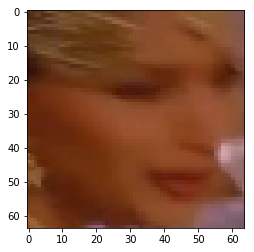

Prediction is NEUTRAL
Actual is HAPPINESS


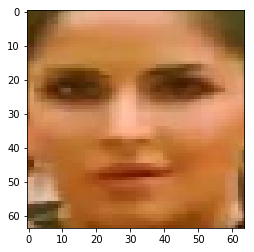

In [306]:
X_train1, X_validate1, y_train1, y_validate1 = train_test_split(X, y_enc, test_size=0.2, random_state=42)
lr=LogisticRegression(C=0.01)
out=get_pca(X_train1,128)
train1=out[0]
test1=out[2].transform(X_validate1)
lr.fit(train1,y_train1)
prediction=lr.predict(test1)
plot=X_validate1.reshape((len(y_validate1),H,W,C))
for i in range(len(y_validate1)):
    if prediction[i]==y_validate1[i]:
        print('Prediction is', str(l1.inverse_transform([prediction[i]])[0]))
        print('Actual is', str(l1.inverse_transform([y_validate1[i]])[0]))
        plt.imshow(plot[i])
        plt.show()
        break
for i in range(len(y_validate1)):
    if prediction[i] !=y_validate1[i]:
        print('Prediction is', str(l1.inverse_transform([prediction[i]])[0]))
        print('Actual is', str(l1.inverse_transform([y_validate1[i]])[0]))
        plt.imshow(plot[i])
        plt.show()
        break

Prediction is centerlight
Actual is centerlight


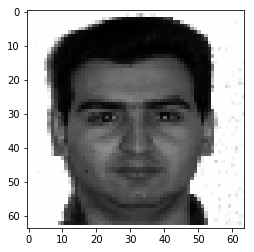

Prediction is sad
Actual is happy


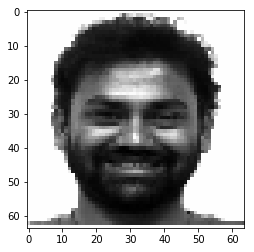

In [307]:
X_train1, X_validate1, y_train1, y_validate1 = train_test_split(X1, y_enc_1, test_size=0.2, random_state=42)
lr=LogisticRegression(C=0.01)
out=get_pca(X_train1,128)
train1=out[0]
test1=out[2].transform(X_validate1)
lr.fit(train1,y_train1)
prediction=lr.predict(test1)
plot=X_validate1.reshape((len(y_validate1),H1,W1,C1))
for i in range(len(y_validate1)):
    if prediction[i]==y_validate1[i]:
        print('Prediction is', str(l2.inverse_transform([prediction[i]])[0]))
        print('Actual is', str(l2.inverse_transform([y_validate1[i]])[0]))
        plt.imshow(plot[i])
        plt.show()
        break
for i in range(len(y_validate1)):
    if prediction[i] !=y_validate1[i]:
        print('Prediction is', str(l2.inverse_transform([prediction[i]])[0]))
        print('Actual is', str(l2.inverse_transform([y_validate1[i]])[0]))
        plt.imshow(plot[i])
        plt.show()
        break